In [1]:
pip install GoogleNews


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 7.8 MB/s 
     |████████████████████████████████| 749 kB 40.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 9.8 MB 33.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
from datetime import datetime,timedelta
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
nltk.download('vader_lexicon')
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from textblob import TextBlob
import numpy as np
#import yfinance as yf
#from block_io import BlockIo


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
def btcnews(dates):
  df=pd.DataFrame()
  
  for date in dates:
    googlenews = GoogleNews()
    googlenews.clear()
    googlenews.set_lang('en')
    googlenews.set_encode('utf-8')
    googlenews.set_time_range(date+timedelta(days=-1),date)
    googlenews.get_news('bitcoin')
    tlist=googlenews.get_texts()
    tdf=pd.DataFrame(tlist,columns =['news'])
    tdf['date']=[date]*tdf.shape[0]
    df=pd.concat([df,tdf])
  return df

def btcpol(dates):
  
  df=btcnews(dates)

  sid = SentimentIntensityAnalyzer()
  df['pos']=df['news'].apply(lambda x: sid.polarity_scores(x)['pos'])
  df['neu']=df['news'].apply(lambda x: sid.polarity_scores(x)['neu'])
  df['neg']=df['news'].apply(lambda x: sid.polarity_scores(x)['neg'])
  df['compound']=df['news'].apply(lambda x: sid.polarity_scores(x)['compound'])
  return df

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

def btcpolb(dates):

  df=btcnews(dates)
  df['pol']=df.news.apply(detect_polarity)
  return df


In [6]:

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]


def get_ema(close,sp):
    ema = close.ewm(span=sp, adjust=False).mean()
    return ema


def get_sma(close,sp):
    sma= close.rolling(sp).mean()
    return sma

def forcefit(a,b):
  M=(b[-1]-b[0])/(a[-1]-a[0])
  C=b[0]-M*a[0]
  return M*a+C
  
  
  #pd.DataFrame(M*a+C,columns = [f'force fitted {list(a)[0]} '],index=b.index)


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime,date
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from scipy.signal import lfilter
from scipy.signal import savgol_filter

Stock to Flow is a method to count the abundance of a particular commodity. This method is commonly used for natural resources or commodities such as gold or silver. Stock to Flow will calculate the value of certain commodities based on their scarcity.

https://coinmetrics.io/community-network-data/#

data source

In [69]:
df_cm =pd.read_csv('/content/btc.csv')


The hypothesis in this study is that scarcity, as measured by SF, directly drives value. A look at the table above confirms that market values tend to be higher when SF is higher. Next step is to collect data and make a statistical model.

In [10]:
df_cm['time']= pd.to_datetime(df_cm['time'])
df_cm['year_month'] = df_cm['time'].apply(lambda x: x.strftime('%Y-%m'))



SF = stock / flow

"It is this consistently low rate of supply of gold that is the fundamental reason it has maintained its monetary role throughout human history."

"The high stock-to-flow ratio of gold makes it the commodity with the lowest price elasticity of supply."

In [11]:
df_s2f = df_cm.groupby(pd.Grouper(key='time',freq='D'))['PriceUSD'].last().to_frame()
df_s2f['flow']= df_cm.groupby(pd.Grouper(key='time',freq='D'))['IssContNtv'].sum().tolist()
df_s2f['stock'] = df_s2f['flow'].cumsum()
df_s2f['s2f'] = df_s2f['stock']/(df_s2f['flow']*463)
n = 15 
b = [1.0 / n] * n
a = 1
df_s2f['s2fkalman']= lfilter(b,a,df_s2f['s2f'])
df_s2f['s2f']= savgol_filter(df_s2f['s2f'], 101, 2)
df_s2f['mcap'] = df_s2f['PriceUSD']*df_s2f['stock']

In [12]:
df_s2f['year_month'] = df_s2f.index
df_s2f['year_month'] = df_s2f['year_month'].apply(lambda x: x.strftime('%Y-%m'))

In [13]:
df_s2f.dropna(inplace=True)
df_s2f.drop(df_s2f.tail(6).index,inplace=True)

In [14]:
df_s2f['ema']=get_ema(df_s2f['PriceUSD'],90)
df_s2f['rsi']=get_rsi(df_s2f['PriceUSD'],30)


In [15]:
start = datetime.strptime('2012-09-11 ', '%Y-%m-%d ')
df_s2f=df_s2f[df_s2f.index>start]


In [16]:
df_s2f['s2fff']=forcefit(get_ema(df_s2f.s2f,30),df_s2f.ema)

In [17]:
plt.rcParams['figure.figsize'] = (20, 12)

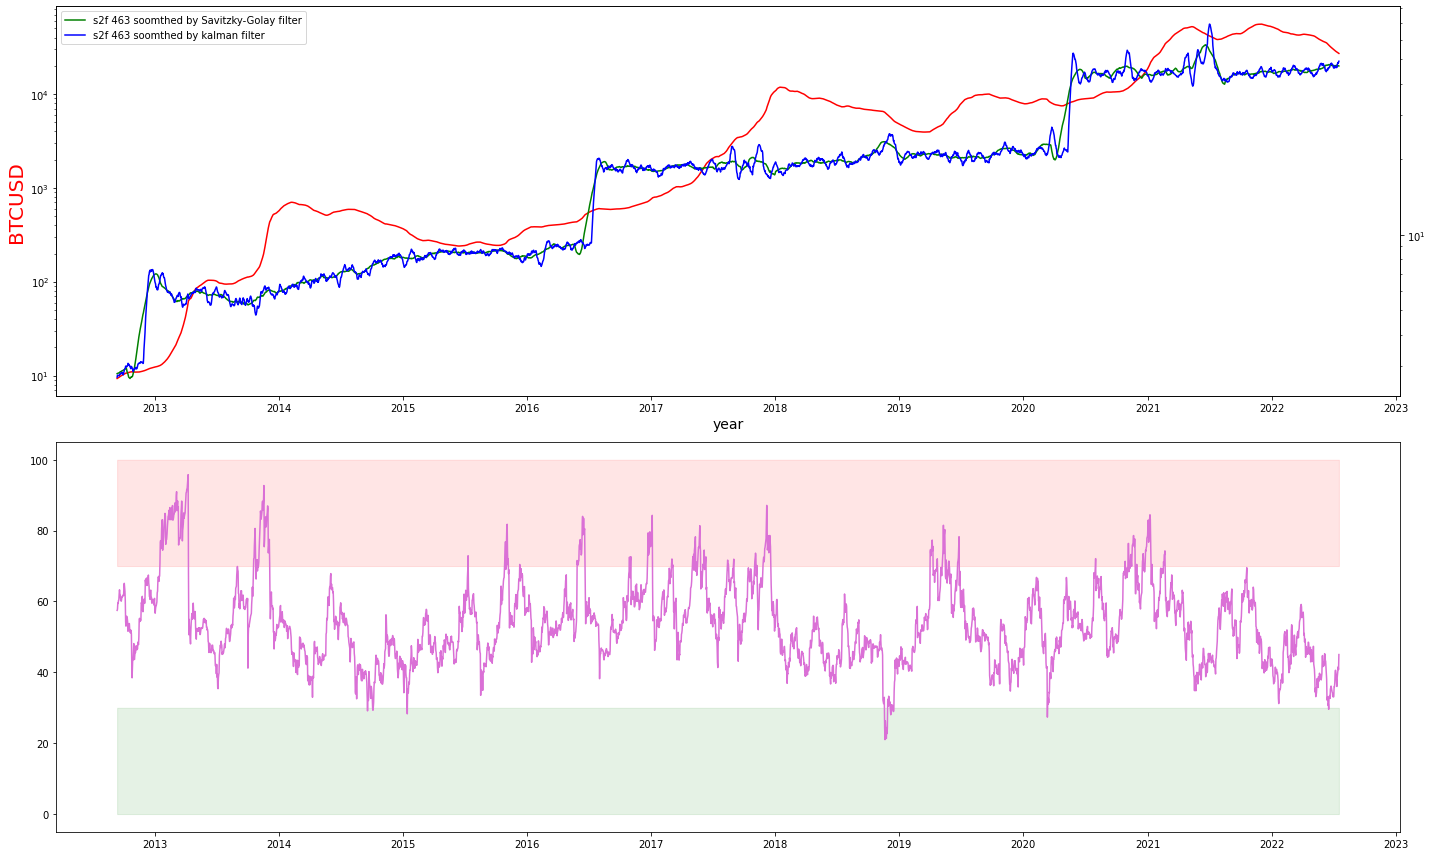

In [19]:
fig,ax = plt.subplots(2)

ax[0].plot(df_s2f.index,
      df_s2f['ema']
        ,color="red",label='EMA')

ax[0].set_xlabel("year", fontsize = 14)
ax[0].set_yscale('log')

ax[0].set_ylabel("BTCUSD",
              color="red",
              fontsize=20)

ax2=ax[0].twinx()


ax2.set_yscale('log')
ax2.plot(df_s2f.index,df_s2f.s2f,label="s2f 463 soomthed by Savitzky-Golay filter",color='green' )







ax2.set_yscale('log')
ax2.plot(df_s2f.index,df_s2f.s2fkalman ,label="s2f 463 soomthed by kalman filter",color='blue')

ax2.legend()



ax[1].plot(df_s2f.index, df_s2f['rsi'],label='RSI 30 days', color="orchid")

fig.tight_layout()

ax[1].fill_between(df_s2f.index, np.ones(len(df_s2f.index))*30, color="green", alpha=0.1)
ax[1].fill_between(df_s2f.index, np.ones(len(df_s2f.index))*70, np.ones(len(df_s2f.index))*100, color="red", alpha=0.1)
plt.show()



plt.show()


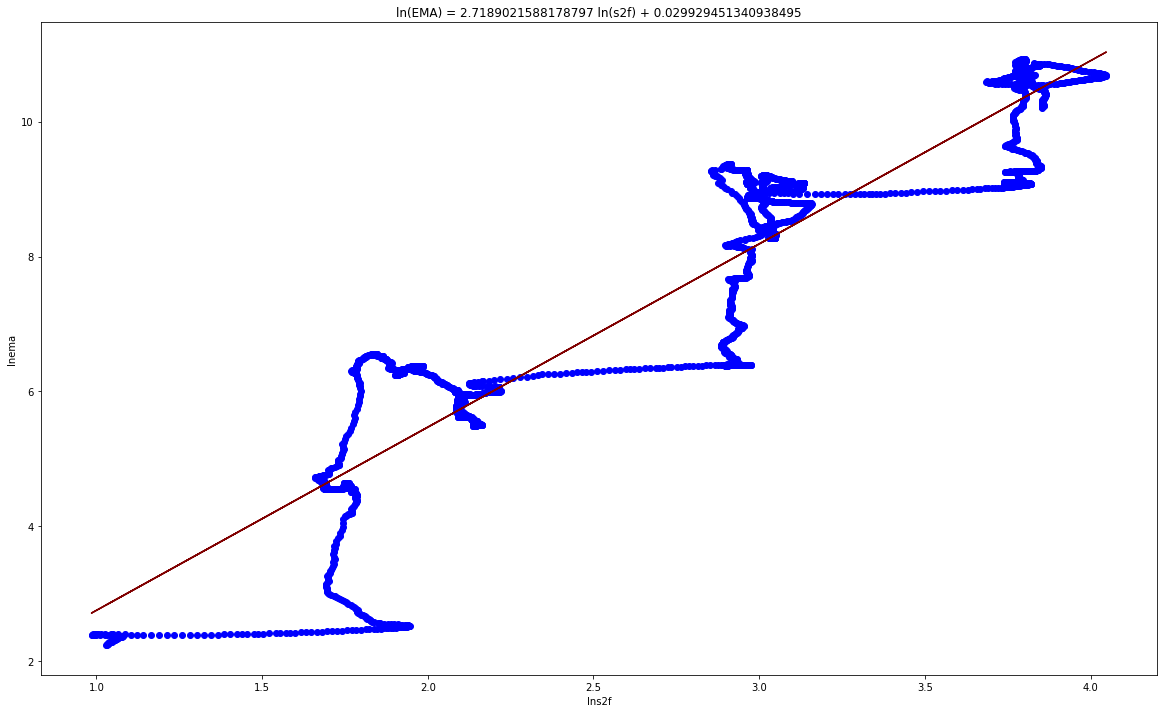

(2.7189021588178797, 0.029929451340938495)

In [20]:
import scipy
from scipy import optimize

def function(x, a, b):
   return a*x + b


y=np.log(df_s2f.ema)

x=np.log(df_s2f['s2f'])


popt,cov = scipy.optimize.curve_fit(function, x, y)
a,b= popt


plt.scatter(x,y,color="blue")
plt.plot(x,function(x, a, b),color="maroon")
plt.xlabel('lns2f')
plt.ylabel('lnema')
#plt.yscale('log')
#plt.xscale('log')
plt.title(f"ln(EMA) = {a} ln(s2f) + {b}")


plt.show()
a,b

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X=scaler.fit(np.log(df_s2f[['s2f','ema']])).fit_transform(np.log(df_s2f[['s2f','ema']]))


df = pd.DataFrame(X, index=df_s2f[['s2f','ema']].index, columns=df_s2f[['s2f','ema']].columns)



In [57]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
x=df.s2f
y=df.ema
x = sm.add_constant(x)
est = sm.OLS(y, x).fit()
[a,b]=list(est.params)
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ema   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 2.057e+04
Date:                Sat, 17 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:33:34   Log-Likelihood:                 3243.1
No. Observations:                3597   AIC:                            -6482.
Df Residuals:                    3595   BIC:                            -6470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0548      0.004     13.031      0.000       0.047       0.063
s2f            0.9574      0.007    143.412      0.000       0.944       0.971
==============================================================================
Omnibus:                      226.633   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.635
Skew:                          -0.654   Prob(JB):                     2.81e-59
Kurtosis:                       3.296   Cond. No.                         5.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Linear Regression')

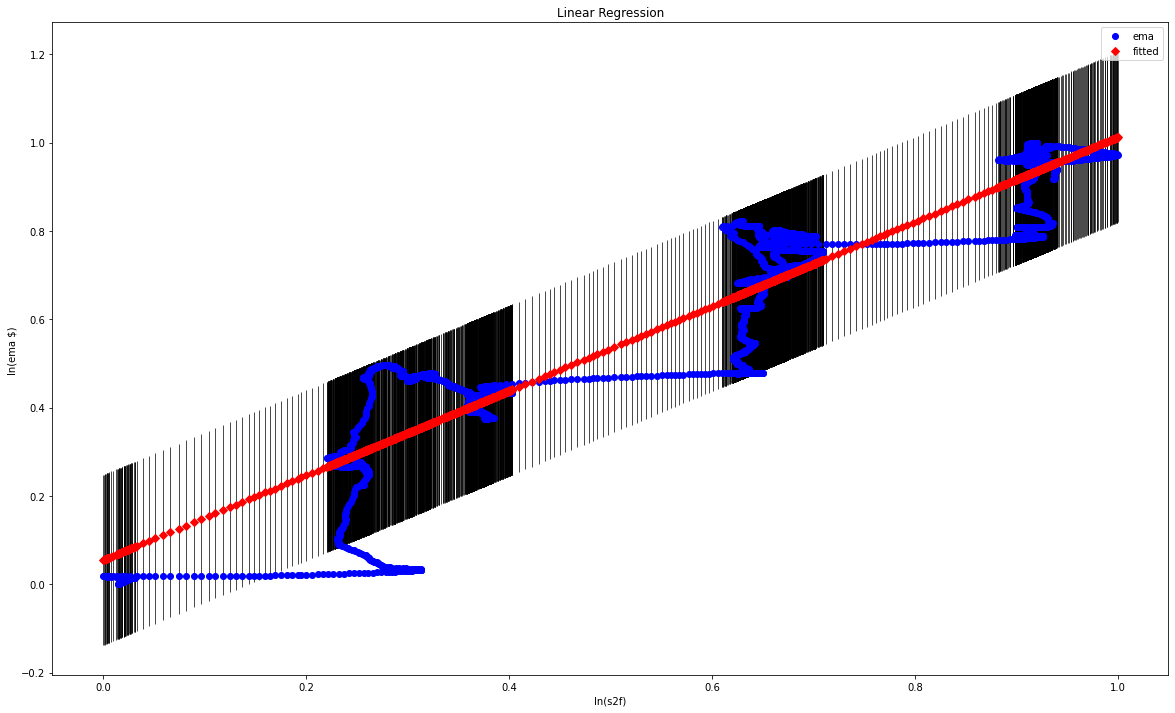

In [58]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(est, 1, ax=ax)
ax.set_ylabel("ln(ema $) ")
ax.set_xlabel("ln(s2f)")
ax.set_title("Linear Regression")

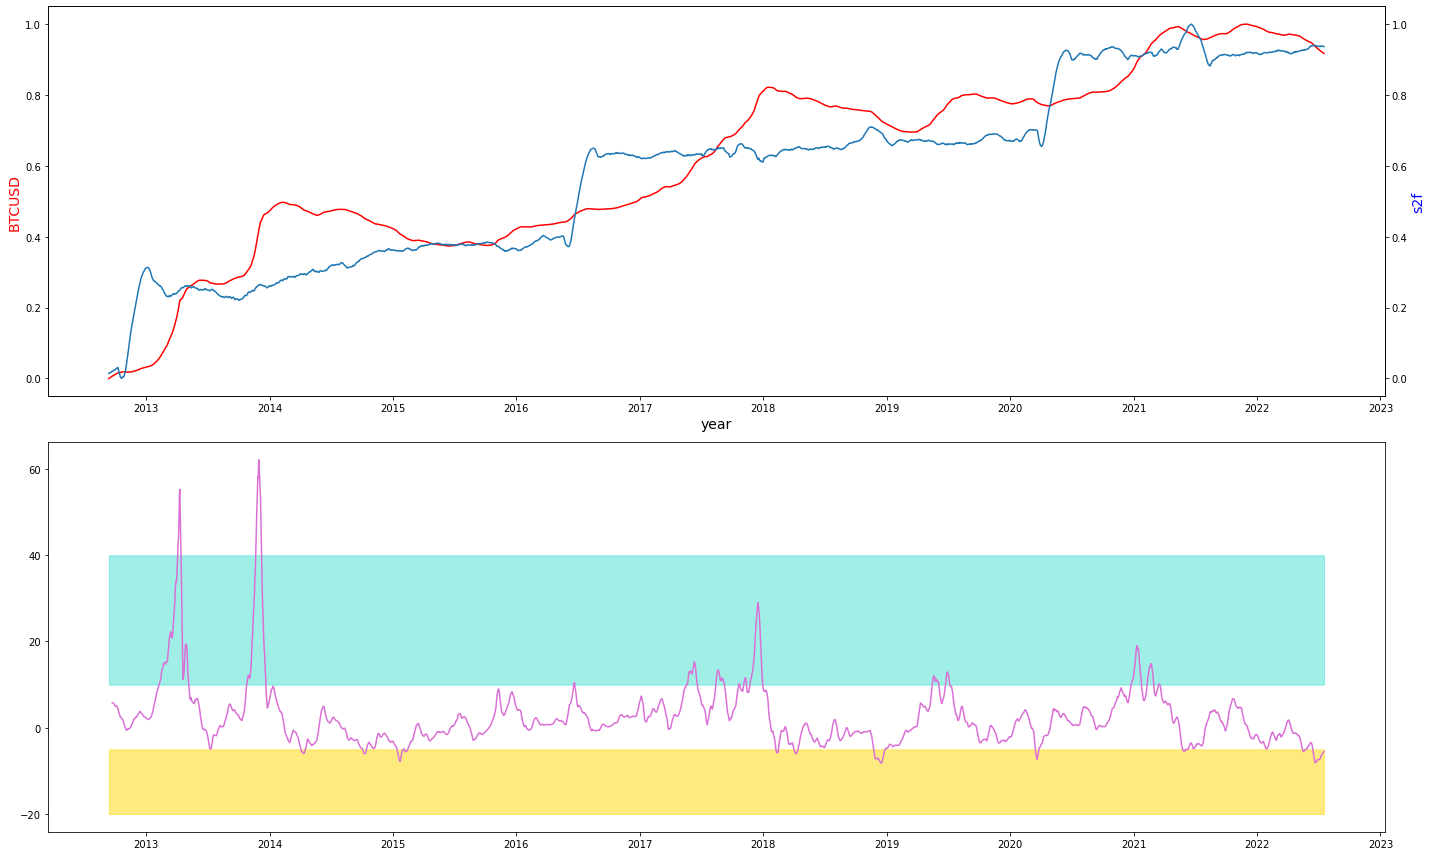

In [59]:
fig,ax = plt.subplots(2)

ax[0].plot(df.index,
         df.ema
         ,color="red")

ax[0].set_xlabel("year", fontsize = 14)
#ax[0].set_yscale('log')

ax[0].set_ylabel("BTCUSD",
              color="red",
              fontsize=14)



ax2=ax[0].twinx()


#ax2.set_yscale('log')
ax2.plot(df.index,df.s2f)

ax2.set_ylabel("s2f",color="blue",fontsize=14)





ax[1].plot(df_s2f.index,  df_s2f['ema'].pct_change(periods=10)*100,color="orchid",label='precentage of change 10 days')

fig.tight_layout()

ax[1].fill_between(df_s2f.index, np.ones(len(df_s2f.index))*-5, np.ones(len(df_s2f.index))*-20, color="gold", alpha=0.5)
ax[1].fill_between(df_s2f.index, np.ones(len(df_s2f.index))*10, np.ones(len(df_s2f.index))*40, color="turquoise", alpha=0.5)
plt.show()



plt.show()


In [45]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
stop_words = ["Crypto", "Bitcoin", "Price",'Will','Cryptocurrency','New','Prices','BTC','Now'] + list(STOPWORDS)

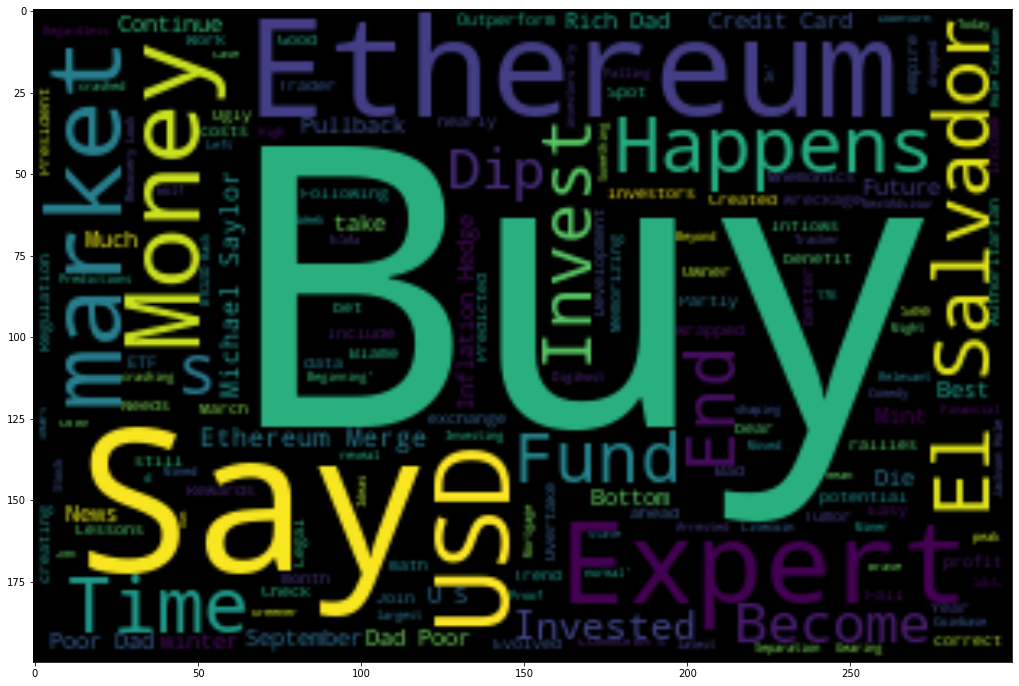

In [65]:
df_s2f['poc']=df_s2f['ema'].pct_change(periods=10)*100
bull=df_s2f[df_s2f['poc']>60]
z=btcpolb(bull.index)
bull=list(bull.index)
bull=btcnews(bull)
allWords = ' '.join([t for t in bull['news']])
wordCloud = WordCloud(width = 300, height=200,stopwords = stop_words, random_state = 21, max_font_size = 120).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')

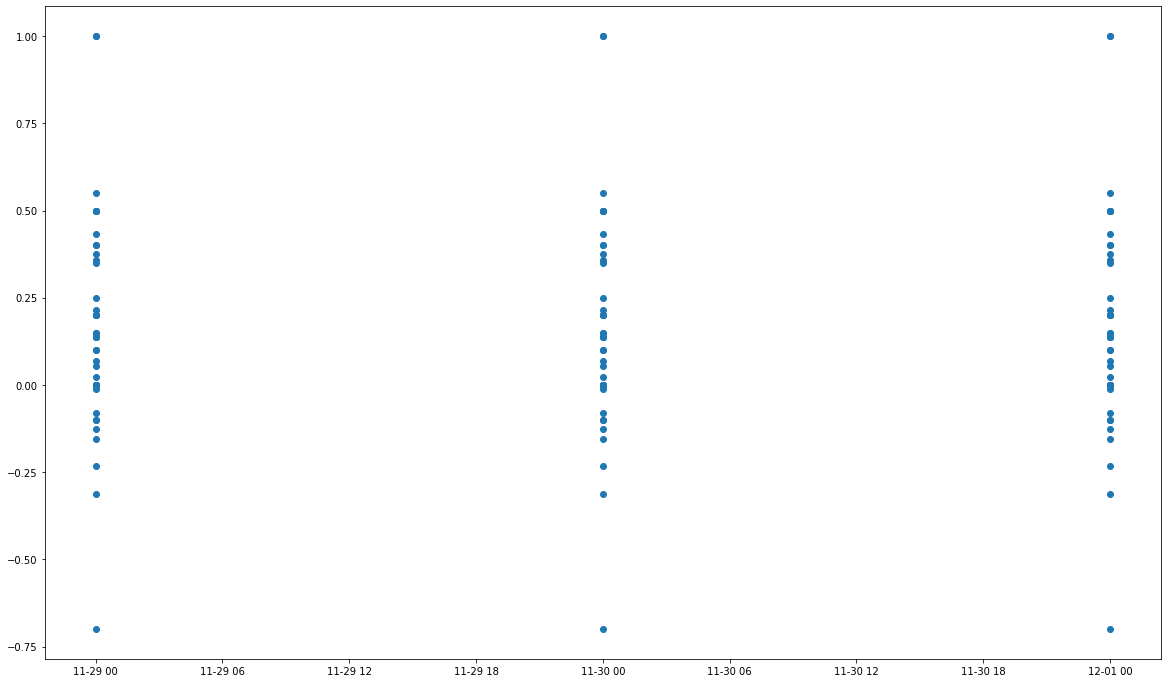

In [67]:
plt.scatter(z.date,z.pol)

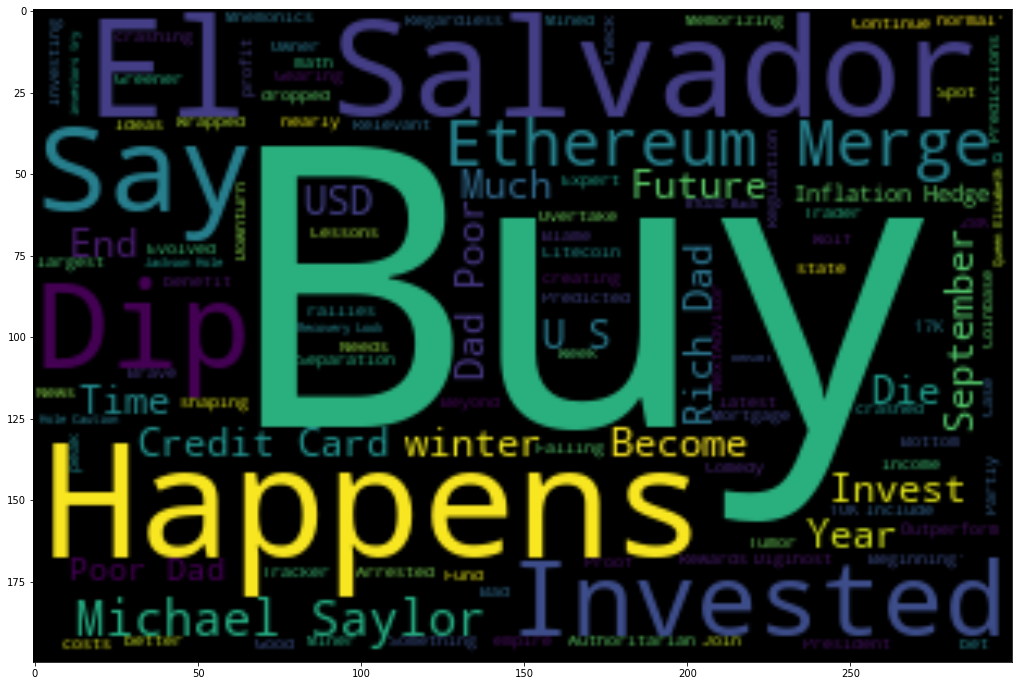

In [68]:
df_s2f['poc']=df_s2f['ema'].pct_change(periods=10)*100
bear=df_s2f[df_s2f['poc']<-8]
z=btcpolb(bear.index)
bear=list(bear.index)
bear=btcnews(bear)
allWords = ' '.join([t for t in bear['news']])
wordCloud = WordCloud(width = 300, height=200,stopwords = stop_words, random_state = 21, max_font_size = 120).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')

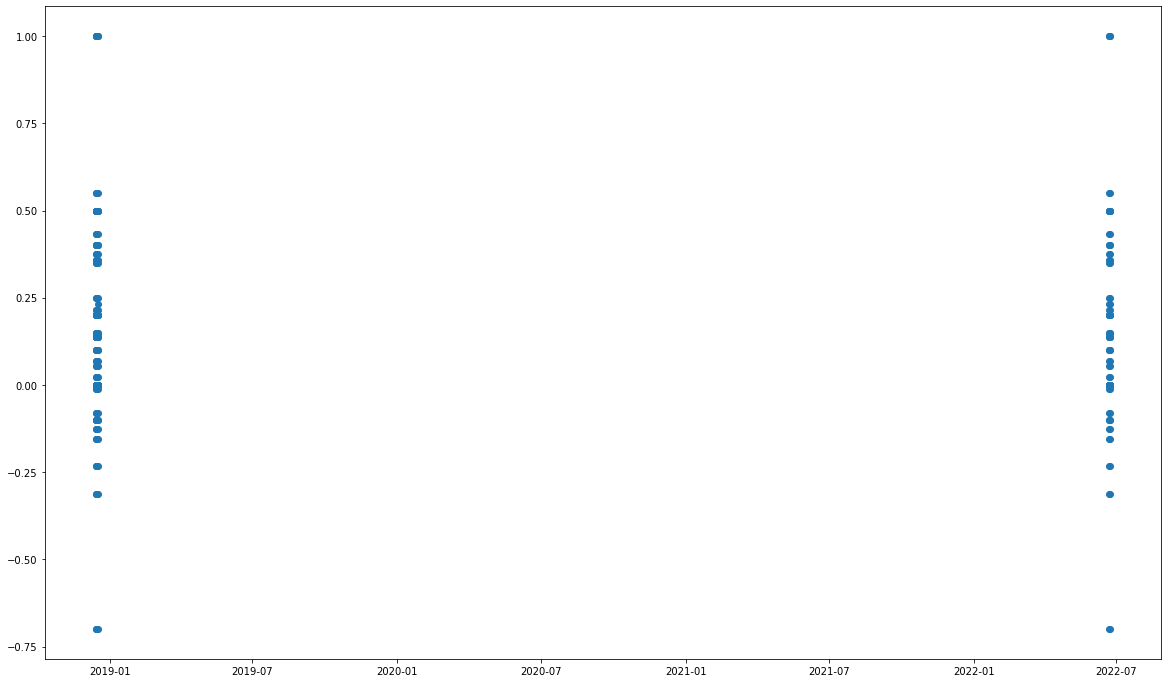

In [70]:
plt.scatter(z.date,z.pol)

In [60]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima import auto_arima

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    print('\n')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print('\n')
    
    if dfoutput['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has unit root and is non-stationary')
        
##############################################################
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    print('\n')
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    print('\n')
    
    if kpss_output['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has unit root and is non-stationary')
    else:        
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has no unit root & is stationary')

In [61]:
df['diff']=df.ema-df.s2f

feed=df['diff']

kpss_test(feed.values)

adf_test(feed.values)


Results of KPSS Test:


Test Statistic            0.263984
p-value                   0.100000
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary
Results of Dickey-Fuller Test:




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Test Statistic                   -3.363941
p-value                           0.012251
#Lags Used                       23.000000
Number of Observations Used    3573.000000
Critical Value (1%)              -3.432182
Critical Value (5%)              -2.862349
Critical Value (10%)             -2.567201
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary


In [62]:
train=feed[:-730]
test=feed[-730:]


In [63]:
model=auto_arima(train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2867
Model:               SARIMAX(1, 1, 2)   Log Likelihood               16326.431
Date:                Sat, 17 Sep 2022   AIC                         -32644.862
Time:                        16:34:38   BIC                         -32621.019
Sample:                    09-12-2012   HQIC                        -32636.265
                         - 07-18-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9659      0.004    215.548      0.000       0.957       0.975
ma.L1         -0.4498      0.013    -34.196      0.000      -0.476      -0.424
ma.L2         -0.0443      0.015     -2.877      0.004      -0.074      -0.014
sigma2       6.59e-07   1.21e-08     54.266      0.000    6.35e-07    6.83e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               717.67
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.06
Prob(H) (two-sided):                  0.20   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:

predictions = model.predict(n_periods=len(test))


The Fourier transform is a mathematical function that decomposes a waveform, which is a function of time, into the frequencies that make it up. The result produced by the Fourier transform is a complex valued function of frequency.

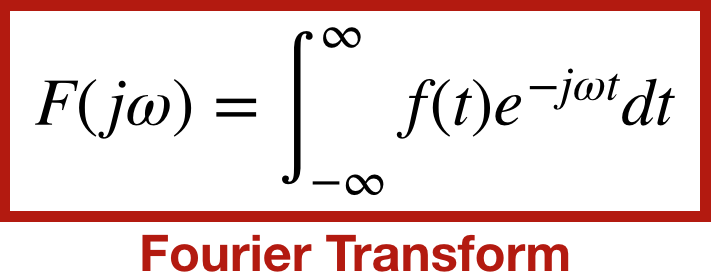

In [73]:
from numpy import fft

def fourierExtrapolation(x, n_predict,harmonics):
    n = x.size
    n_harm = harmonics               
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)        
    x_notrend = x - p[0] * t      
    x_freqdom = fft.fft(x_notrend)  
    f = fft.fftfreq(n)             
    indexes = range(n)

    indexes = list(range(n))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  
        phase = np.angle(x_freqdom[i])        
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return (restored_sig + p[0] * t)



best number harmonics is 6


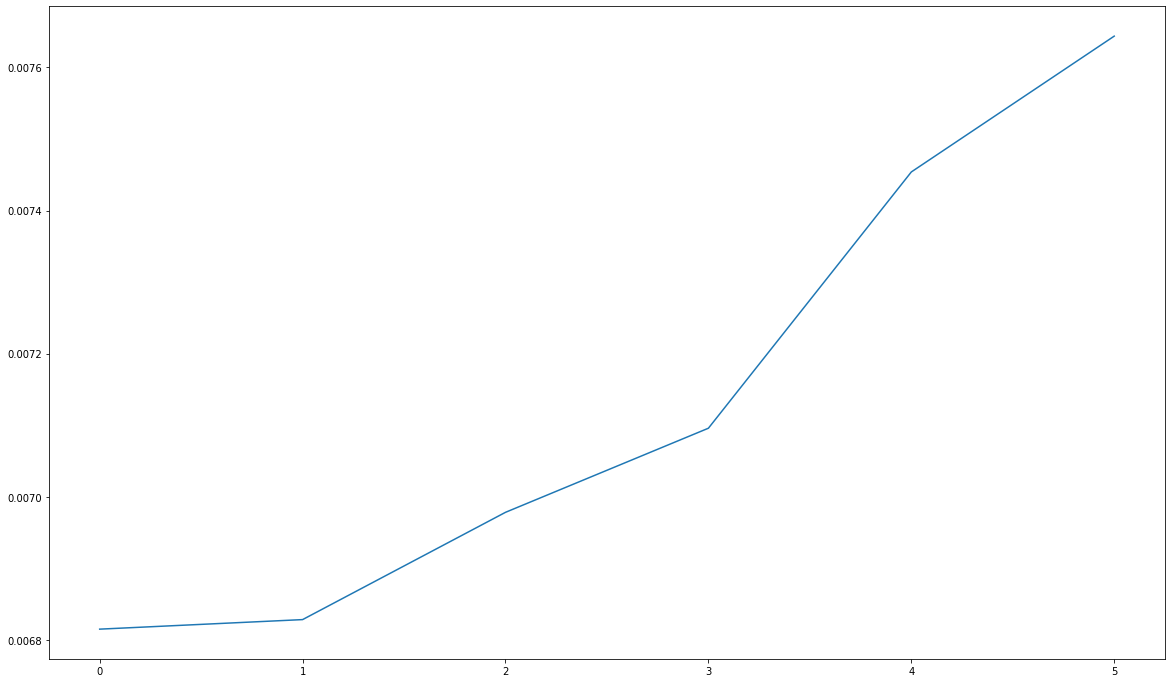

In [75]:
from sklearn.metrics  import mean_squared_error as mse
def f(x):
  y=mse(fourierExtrapolation(train,len(test),x)[-1*len(test):],test)
  return y


l=[]

z=99999999
for i in range(20):
  
  if f(i)<z:
    z=f(i)
    l=[z]+l
    a=i
  

plt.plot(l)
print(f'best number harmonics is {a}')

In [76]:
df['test']=test
df['train']=train
df['arima']=predictions
df['fourier']=fourierExtrapolation(train.values, len(test),6)



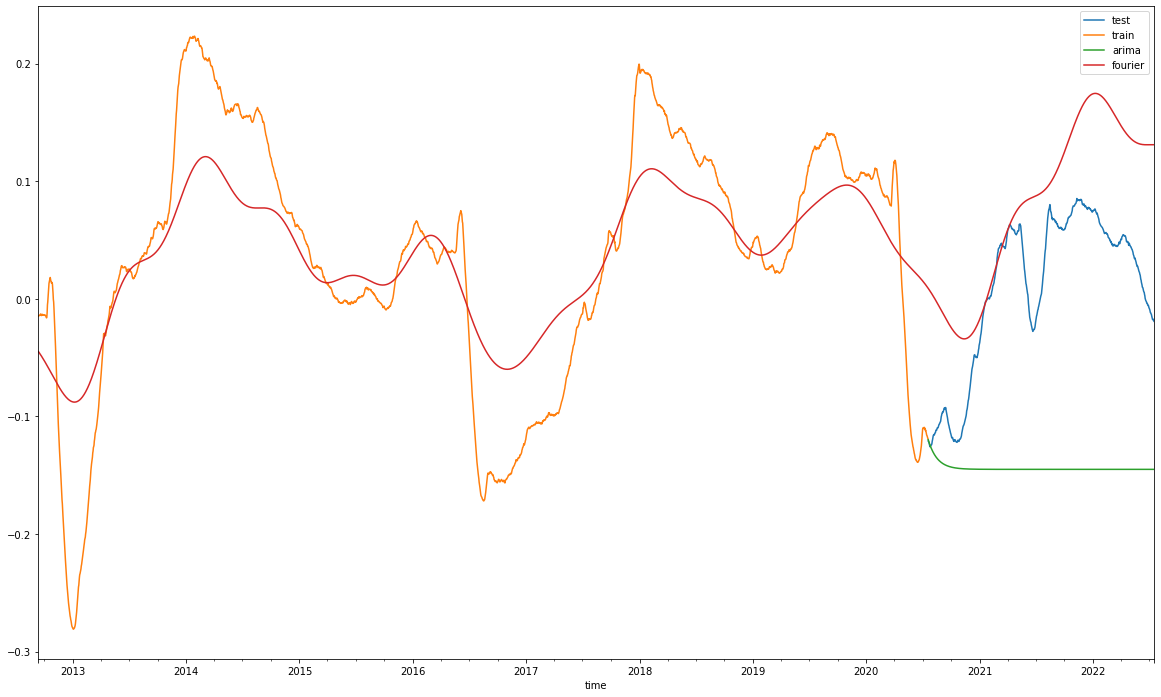

In [77]:
df.test.plot(legend=True)
df.train.plot(legend=True)
df.arima.plot(legend="arima")
df.fourier.plot(legend="fourier");

In [ ]:
df['fcast']=df['s2f']+df['fourier']


X=scaler.inverse_transform(df[['s2f','fcast']])

X=np.exp(X)

# scaler = MinMaxScaler()

# X=scaler.fit(np.log(df_s2f[['s2f','ema']])).fit_transform(np.log(df_s2f[['s2f','ema']]))


dff = pd.DataFrame(X, index=df[['s2f','fcast']].index, columns=df[['s2f','fcast']].columns)





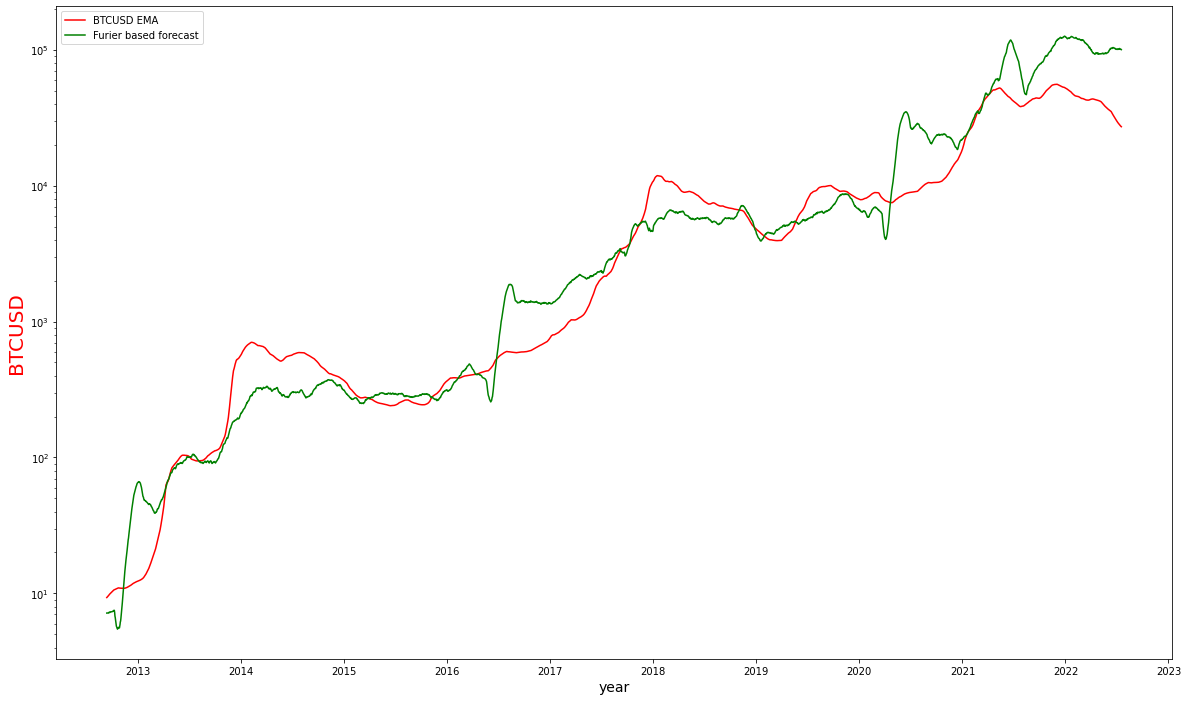

In [ ]:
fig,ax = plt.subplots()

ax.plot(df_s2f.index,
      df_s2f['ema']
        ,color="red")

ax.set_xlabel("year", fontsize = 14)
ax.set_yscale('log')

ax.set_ylabel("BTCUSD",
              color="red",
              fontsize=20)





ax.plot(dff.index,dff.fcast,color='green' )

ax.legend(['BTCUSD EMA', 'Furier based forecast'])


Future works:

Although fourier transform based price prediction did not have desirable accuracy on forecasting price with this method , this research has shown that it will be useful to extrapolate(forecast) the general pattern of price fluctuations during the test period.
Moreover, it worths to put more effort in order to optimize the fourier transform method using advanced optimization tools to tune more acuurate prediction algorithms.

Also , instead of classic time series modeling methods Neuralnetworks namely LSTM may be more desirable tool in this sorth if algorthems.


Refrences:


https://medium.com/@burdivelam/using-k-means-on-the-s2fx-model-of-planb-be8909248828


https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25


https://gist.github.com/tartakynov/83f3cd8f44208a1856ce



https://coinmetrics.io/community-network-data/#

